In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from textblob import TextBlob
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))
import re
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD   

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
drinking_path='drive/My Drive/modeling project/stopdrinking.csv'
smoking_path='drive/My Drive/modeling project/stopsmoking.csv'
col_names = ['author',#Provides an instance of Redditor.
'author_created_utc',
'author_flair_background_color',
'author_flair_css_class',
'author_flair_richtext',
'author_flair_template_id',
'author_flair_text',
'author_flair_text_color',
'author_flair_type',
'author_fullname',
'author_patreon_flair',
'body', #	The body of the comment.
'can_gild',
'can_mod_post',
'collapsed',
'collapsed_reason',
'controversiality',
'created_utc', #Time the comment was created, represented in Unix Time.
'distinguished',#Whether or not the comment is distinguished.
'edited',#Whether or not the comment has been edited.
'gilded',
'gildings',
'id',#The ID of the comment.
'is_submitter',#Whether or not the comment author is also the author of the submission.
'link_id',#The submission ID that the comment belongs to.
'no_follow',
'parent_id',#The ID of the parent comment. If it is a top-level comment, this returns the submission ID instead (prefixed with ‘t3’).
'permalink',#A permalink for the comment. Comment objects from the inbox have a context attribute instead.
'removal_reason',
'retrieved_on',
'score',#The number of upvotes for the comment.
'send_replies',
'stickied',#Whether or not the comment is stickied.
'subreddit',#Provides an instance of Subreddit. The subreddit that the comment belongs to.
'subreddit_id',#The subreddit ID that the comment belongs to.
'subreddit_name_prefixed',
'subreddit_type']
useful_col = ['author','author_created_utc','author_flair_text_color','author_flair_type','author_fullname','author_patreon_flair','body','created_utc','id','is_submitter','link_id','no_follow','parent_id','permalink','retrieved_on','score','send_replies','subreddit_id']

In [ ]:
smoking = pd.read_csv(smoking_path,error_bad_lines=False,skiprows=2,engine='python',warn_bad_lines=False,names=col_names,index_col=False)
drinking = pd.read_csv(drinking_path,error_bad_lines=False,warn_bad_lines=False,engine='python',names=col_names,index_col=False)


smoking = smoking[(smoking.can_mod_post=='True')|(smoking.can_mod_post=='False')]

smoking = smoking[(smoking.send_replies=='True')|(smoking.send_replies=='False')]

smoking = smoking[smoking.subreddit=='stopsmoking']

smoking = smoking[(smoking.author_flair_text_color=='None')|(smoking.author_flair_text_color=='dark')]

smoking = smoking[useful_col]



drinking = drinking[(drinking.can_mod_post=='True')|(drinking.can_mod_post=='False')]

drinking = drinking[(drinking.send_replies=='True')|(drinking.send_replies=='False')]

drinking = drinking[drinking.subreddit=='stopdrinking']

drinking = drinking[(drinking.author_flair_text_color=='None')|(drinking.author_flair_text_color=='dark')]

drinking = drinking[useful_col]

In [ ]:
smoking['score']=smoking['score'].map(int)
drinking['score']=drinking['score'].map(int)

In [ ]:
smoking.head()

,author,author_created_utc,author_flair_text_color,author_flair_type,author_fullname,author_patreon_flair,body,created_utc,id,is_submitter,link_id,no_follow,parent_id,permalink,retrieved_on,score,send_replies,subreddit_id
19,False,raccoonnnnn,None,None,text,t2_111jjnu2,Great reminder of why we quit! https://youtu....,1538361877,e6y4djo,False,t3_9k78ks,True,t1_e6wywwy,/r/stopsmoking/comments/9k78ks/here_it_is_my_o...,1539899530,2,True,t5_2rbuf
20,False,Terracottapanacotta,None,None,text,t2_213edw85,Congratulations!! Do you still experience crav...,1538362370,e6y4uj3,False,t3_9kbhto,True,t3_9kbhto,/r/stopsmoking/comments/9kbhto/i_did_this_desp...,1539899740,4,True,t5_2rbuf
21,False,CobraCommander117,None,None,text,t2_2blo0dau,I’m with you! Clearing my ashtrays tonight!,1538362791,e6y590r,False,t3_9k58jn,True,t3_9k58jn,/r/stopsmoking/comments/9k58jn/let_try_to_hit_...,1539899912,1,True,t5_2rbuf
23,False,Duckniggits,None,None,text,t2_splni,I'm all in I just got some friends in on this ...,1538363237,e6y5o9e,False,t3_9k58jn,True,t3_9k58jn,/r/stopsmoking/comments/9k58jn/let_try_to_hit_...,1539900097,1,True,t5_2rbuf
26,False,throwawaykitty1200,None,None,text,t2_2088dczv,That's great! Good luck!,1538363905,e6y6bcx,False,t3_9kbvgd,True,t3_9kbvgd,/r/stopsmoking/comments/9kbvgd/here_we_go_guys...,1539900373,1,True,t5_2rbuf


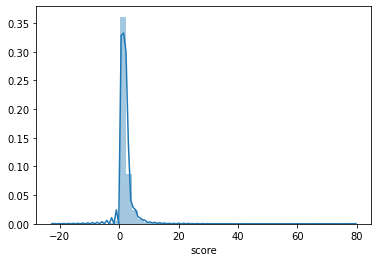

In [ ]:
sns.distplot(smoking['score'])

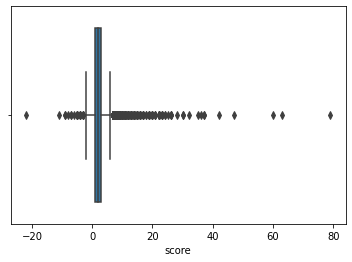

In [ ]:
sns.boxplot(smoking['score'])

In [ ]:
len(smoking[smoking['score']>6])

392

In [ ]:
len(smoking)

11027

Sentiment

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!pip install transformers
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [ ]:
from torchtext import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
LABEL.build_vocab(train_data)

In [ ]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)


def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 5

best_valid_loss = float('inf')

model.load_state_dict(torch.load('drive/My Drive/tut6-model-tuned.pt'))

def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()



Sampling

In [ ]:
smoking['class']=smoking['score'].map(lambda x:1 if x >=6 else 0)
sum(smoking['class']==1)/len(smoking)

0.05268885462954566

In [ ]:
smoke = smoking.sample(n=3000,random_state=0).reset_index(drop=True)
sum(smoke['class']==1)/len(smoke)

0.05433333333333333

In [ ]:
drinking['class']=drinking['score'].map(lambda x:1 if x >=6 else 0)
sum(drinking['class']==1)/len(drinking)

0.08590939216057565

In [ ]:
drink = drinking.sample(n=3000,random_state=0).reset_index(drop=True)
sum(drink['class']==1)/len(drink)

0.08833333333333333

sentiment

In [ ]:
smoke['sentiment']=smoke['body'].map(lambda x:predict_sentiment(model, tokenizer, x))
smoke.to_csv('drive/My Drive/smoke+sentiment.csv')

Text(0.5, 1.0, 'Sentiment Distribution of Smoking')

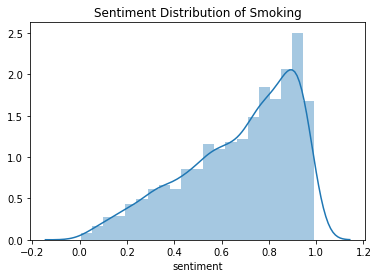

In [ ]:
#smoke=pd.read_csv('drive/My Drive/smoke+all.csv')
#sns.distplot(smoke['sentiment'])
#plt.title('Sentiment Distribution of Smoking')

In [ ]:
drink['sentiment']=drink['body'].map(lambda x:predict_sentiment(model, tokenizer, x))
drink.to_csv('drive/My Drive/drink+sentiment.csv')

Text(0.5, 1.0, 'Sentiment Distribution of Drinking')

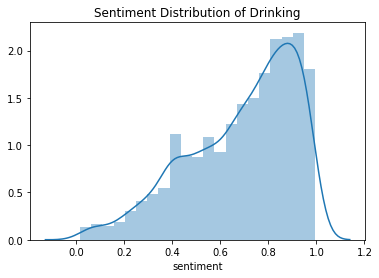

In [ ]:
drink=pd.read_csv('drive/My Drive/drink+all.csv')
sns.distplot(drink['sentiment'])
plt.title('Sentiment Distribution of Drinking')

topic

In [ ]:
smoke=pd.read_csv('drive/My Drive/smoke+sentiment.csv')
drink=pd.read_csv('drive/My Drive/drink+sentiment.csv')

In [ ]:
#topic
vectorizer = CountVectorizer(stop_words='english')
x = vectorizer.fit_transform(smoke['body'])
lsa = TruncatedSVD(5)                           
x2 = lsa.fit_transform(x)

terms = vectorizer.get_feature_names()

n_pick_keywords = 4

topic_keywords_id = [lsa.components_[t].argsort()[:-(n_pick_keywords+1):-1] for t in range(5)]

for t in range(5):
    print("topic %d:" % t)
    print("    keywords: %s" % ", ".join(terms[topic_keywords_id[t][j]] for j in range(n_pick_keywords)))

x2=pd.DataFrame(x2,columns=['t1','t2','t3','t4','t5'])
smoke=pd.concat([smoke,x2],axis=1)

smoke.to_csv('drive/My Drive/smoke+all.csv')

topic 0:
    keywords: smoking, just, quit, smoke
topic 1:
    keywords: smoking, don, quit, smoke
topic 2:
    keywords: quit, years, good, turkey
topic 3:
    keywords: just, don, smoke, nicotine
topic 4:
    keywords: nicotine, com, https, amp


In [ ]:

vectorizer = CountVectorizer(stop_words='english')
x = vectorizer.fit_transform(drink['body'])
lsa = TruncatedSVD(5)                           
x2 = lsa.fit_transform(x)
terms = vectorizer.get_feature_names()

n_pick_keywords = 4

topic_keywords_id = [lsa.components_[t].argsort()[:-(n_pick_keywords+1):-1] for t in range(5)]

for t in range(5):
    print("topic %d:" % t)
    print("    keywords: %s" % ", ".join(terms[topic_keywords_id[t][j]] for j in range(n_pick_keywords)))

x2=pd.DataFrame(x2,columns=['t1','t2','t3','t4','t5'])
drink=pd.concat([drink,x2],axis=1)

drink.to_csv('drive/My Drive/drink+all.csv')

topic 0:
    keywords: just, drinking, drink, like
topic 1:
    keywords: drink, today, day, days
topic 2:
    keywords: drinking, drink, just, don
topic 3:
    keywords: drinking, day, time, years
topic 4:
    keywords: just, time, thank, better


visualisation

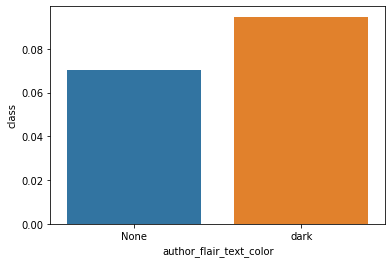

In [ ]:
p = drink.groupby('author_flair_text_color',as_index=False)['class'].mean()

sns.barplot(x='author_flair_text_color',y='class',data=p)


In [ ]:
drink['author_flair_text_color'].value_counts()

dark    2217
None     783
Name: author_flair_text_color, dtype: int64

In [ ]:
drink['is_submitter'].value_counts()

False    2506
True      494
Name: is_submitter, dtype: int64

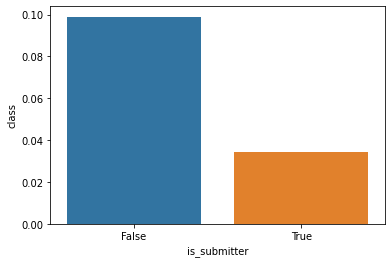

In [ ]:
p = drink.groupby('is_submitter',as_index=False)['class'].mean()

sns.barplot(x='is_submitter',y='class',data=p)

In [ ]:
drink['no_follow'].value_counts()

True     2493
False     507
Name: no_follow, dtype: int64

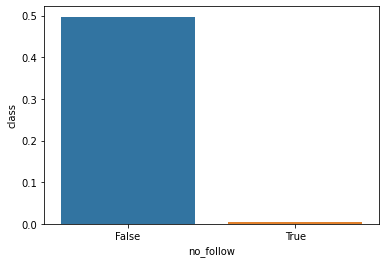

In [ ]:
p = drink.groupby('no_follow',as_index=False)['class'].mean()

sns.barplot(x='no_follow',y='class',data=p)

In [ ]:
#author_flair_text_color
#body
#is_submitter
#no_follow
#score

split

In [ ]:
smoke=pd.read_csv('drive/My Drive/smoke+all.csv')
smoke=smoke[['author_flair_text_color','body','is_submitter','no_follow','score','class','sentiment','t1','t2','t3','t4','t5']]
smoke=pd.get_dummies(smoke,columns=['author_flair_text_color','is_submitter','no_follow'],drop_first=True)
trainx,testx,trainy,testy=train_test_split(smoke.drop(columns={'class','score','body'},axis=1),smoke['class'],test_size=0.3,random_state=99)
train=pd.concat([trainx,trainy],axis=1)
train0 = train[train['class']==0]
train1 = train[train['class']==1]
train_upsampled = resample(train1,replace=True,  # sample with replacement
                             n_samples=len(train0),  # to match majority class
                             random_state=1)  # reproducible results
trainup=pd.concat([train0,train_upsampled],axis=0)
trainx1=trainup.drop(columns={'class'},axis=1)
trainy1=trainup['class']
sum(trainup['class']==1)/len(trainup)

0.5

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection  import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
def confusion(cnf_matrix,name='Confusion matrix'):
  class_names=[0,1]   
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
# create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True,fmt='g',cmap='Blues')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title(name, y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [ ]:
#random forest #smoke

In [ ]:
model_rf = RandomForestClassifier(random_state=0)
params = {'n_estimators': [50,100,300], 'max_depth': range(5,9),'min_samples_leaf':[10,20,50]}
grid = GridSearchCV(model_rf, params,cv=5).fit(trainx1, trainy1)
print(grid.best_params_['n_estimators'])
print(grid.best_params_['max_depth'])
print(grid.best_params_['min_samples_leaf'])
print ("score", grid.best_score_)
print ("params", grid.best_params_)

100
8
10
score 0.9438029864589719
params {'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 100}


In [ ]:
model_rf= RandomForestClassifier(n_estimators=100, max_depth=8,min_samples_leaf=10)
model_rf.fit(trainx1,trainy1)
prd=model_rf.predict(testx)
print  (accuracy_score(trainy1, model_rf.predict(trainx1)))
print  (accuracy_score(testy, prd))
c = confusion_matrix(testy,prd)
print(confusion_matrix(testy,prd))
print(classification_report(testy,prd))
print(roc_auc_score(testy,prd))

0.9569052419354839
0.9277777777777778
[[801  52]
 [ 13  34]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       853
           1       0.40      0.72      0.51        47

    accuracy                           0.93       900
   macro avg       0.69      0.83      0.74       900
weighted avg       0.95      0.93      0.94       900

0.8312214711531266


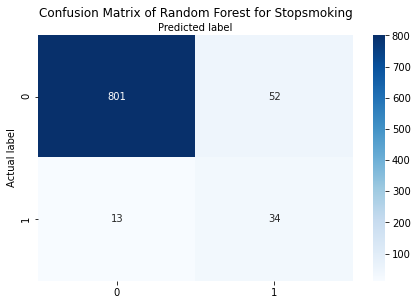

In [ ]:
confusion(c,'Confusion Matrix of Random Forest for Stopsmoking')

Text(0.5, 1.0, 'Feature Importance for Stopsmoking')

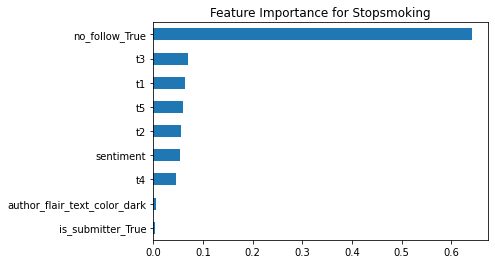

In [ ]:

feat_importances = pd.Series(model_rf.feature_importances_, trainx1.columns)
feat_importances = feat_importances.sort_values()
feat_importances.plot(kind='barh')
plt.title('Feature Importance for Stopsmoking')

In [ ]:
#logistic #smoke

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(trainx1, trainy1)
prd=model_lr.predict(testx)
print  (accuracy_score(trainy1, model_lr.predict(trainx1)))
print  (accuracy_score(testy, prd))

print(confusion_matrix(testy,prd))
print(classification_report(testy,prd))
print(roc_auc_score(testy,prd))

0.8709677419354839
0.9188888888888889
[[793  60]
 [ 13  34]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       853
           1       0.36      0.72      0.48        47

    accuracy                           0.92       900
   macro avg       0.67      0.83      0.72       900
weighted avg       0.95      0.92      0.93       900

0.8265321393829039


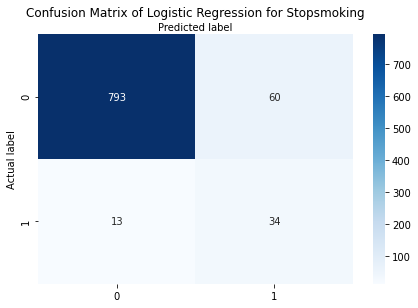

In [ ]:
c = confusion_matrix(testy,prd)
confusion(c,'Confusion Matrix of Logistic Regression for Stopsmoking')

In [ ]:
#xgboost #smoke

In [ ]:
eval_set = [(trainx1, trainy1), (testx, testy)]
eval_metric = ['auc']
model=XGBClassifier()
%time model.fit(trainx1, trainy1, eval_metric=eval_metric,eval_set=eval_set, verbose=True,early_stopping_rounds=200)

[0]	validation_0-auc:0.919821	validation_1-auc:0.84519
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.923052	validation_1-auc:0.848782
[2]	validation_0-auc:0.933349	validation_1-auc:0.863186
[3]	validation_0-auc:0.932855	validation_1-auc:0.862288
[4]	validation_0-auc:0.939179	validation_1-auc:0.877204
[5]	validation_0-auc:0.939783	validation_1-auc:0.873837
[6]	validation_0-auc:0.93958	validation_1-auc:0.883665
[7]	validation_0-auc:0.941081	validation_1-auc:0.887157
[8]	validation_0-auc:0.940745	validation_1-auc:0.884712
[9]	validation_0-auc:0.944391	validation_1-auc:0.884737
[10]	validation_0-auc:0.945073	validation_1-auc:0.881569
[11]	validation_0-auc:0.946408	validation_1-auc:0.880921
[12]	validation_0-auc:0.948154	validation_1-auc:0.884737
[13]	validation_0-auc:0.948645	validation_1-auc:0.883727
[14]	validation_0-auc:0.948142	validation_1-auc:0.882617

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

<Figure size 720x360 with 0 Axes>

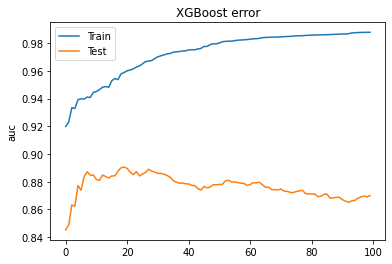

In [ ]:
import matplotlib.pyplot as plt
results=model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost error')
plt.show()

In [ ]:
param_test1 = {
     'learning_rate':[i/10.0 for i in range(1,4)], #0.3
     'n_estimators':range(50,500,50) #400
    }

param_test2 = {
     'max_depth':range(3,10,2), #9
     'min_child_weight':range(1,6,2) #1
    }
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)] # 0.0
    }
param_test4 = {
     'subsample':[i/10.0 for i in range(6,11)], #0.6
     'colsample_bytree':[i/10.0 for i in range(6,11)] #0.8
    }
param_test5 = {
        'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05] #0.05
    }

grid = GridSearchCV(estimator = XGBClassifier(
        objective= 'binary:logistic', 
        learning_rate=0.1,
        n_estimators=500,
        #max_depth=5,
        #min_child_weight=1,
        #gamma=0,
        #colsample_bytree=0.6,
        #subsample=0.6,
        #reg_alpha=0
        nthread=4, 
        scale_pos_weight=1,
        seed=0), 
    param_grid = param_test2, 
    scoring='aucpr',
    n_jobs=4,iid=False, cv=5)
grid.fit(trainx1,trainy1)

print("grid.best_params_", grid.best_params_)
print("grid.best_score_", grid.best_score_)

In [ ]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=450, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)

In [ ]:
clf=XGBClassifier(objective= 'binary:logistic', 
        learning_rate=0.3,
        n_estimators=450,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        colsample_bytree=0.6,
        subsample=0.6,
        #reg_alpha=0,
        nthread=4, 
        scale_pos_weight=1,
        seed=0)

In [ ]:
clf=grid.best_estimator_
#clf=XGBClassifier()
clf.fit(trainx1,trainy1)

y_train_pred = clf.predict(trainx1)
train_predictions = [round(value) for value in y_train_pred]

y_test_pred = clf.predict(testx)
test_predictions = [round(value) for value in y_test_pred]

print  (accuracy_score(trainy1, y_train_pred))
print  (accuracy_score(testy, y_test_pred))

print(confusion_matrix(testy,y_test_pred))
print(classification_report(testy,y_test_pred))
print(roc_auc_score(testy,y_test_pred))

0.9997479838709677
0.9344444444444444
[[823  30]
 [ 29  18]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       853
           1       0.38      0.38      0.38        47

    accuracy                           0.93       900
   macro avg       0.67      0.67      0.67       900
weighted avg       0.94      0.93      0.93       900

0.6739043675637922


In [ ]:
#svm

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') 
#poly 0.819
#rbf 0.810
#sigmoid 0.739
clf.fit(trainx1, trainy1)

#Predict the response for test dataset
y_test_pred = clf.predict(testx)
y_train_prd=clf.predict(trainx1)
print  (accuracy_score(trainy1, y_train_prd))
print  (accuracy_score(testy, y_test_pred))

print(confusion_matrix(testy,y_test_pred))
print(classification_report(testy,y_test_pred))
print(roc_auc_score(testy,y_test_pred))

0.8686995967741935
0.9277777777777778
[[801  52]
 [ 13  34]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       853
           1       0.40      0.72      0.51        47

    accuracy                           0.93       900
   macro avg       0.69      0.83      0.74       900
weighted avg       0.95      0.93      0.94       900

0.8312214711531266


In [ ]:
trainx1.columns

Index(['sentiment', 't1', 't2', 't3', 't4', 't5',
       'author_flair_text_color_dark', 'is_submitter_True', 'no_follow_True'],
      dtype='object')

In [ ]:
clf.coef_

array([[-1.91846459e-05,  1.08639358e-05, -1.49726518e-05,
        -3.23823394e-05,  3.11496483e-05,  2.16524282e-06,
        -1.93783167e-05,  5.30351086e-07, -1.99999899e+00]])

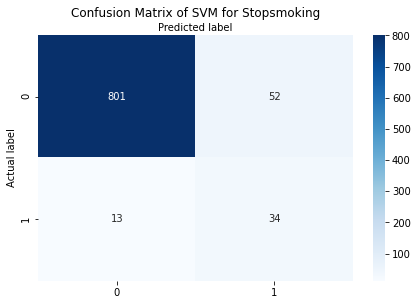

In [ ]:
c = confusion_matrix(testy,y_test_pred)
confusion(c,'Confusion Matrix of SVM for Stopsmoking')

In [ ]:
#drink

In [ ]:
smoke=pd.read_csv('drive/My Drive/drink+all.csv')
smoke=smoke[['author_flair_text_color','body','is_submitter','no_follow','score','class','sentiment','t1','t2','t3','t4','t5']]
smoke=pd.get_dummies(smoke,columns=['author_flair_text_color','is_submitter','no_follow'],drop_first=True)
trainx,testx,trainy,testy=train_test_split(smoke.drop(columns={'class','score','body'},axis=1),smoke['class'],test_size=0.3,random_state=99)
train=pd.concat([trainx,trainy],axis=1)
train0 = train[train['class']==0]
train1 = train[train['class']==1]
train_upsampled = resample(train1,replace=True,  # sample with replacement
                             n_samples=len(train0),  # to match majority class
                             random_state=1)  # reproducible results
trainup=pd.concat([train0,train_upsampled],axis=0)
trainx1=trainup.drop(columns={'class'},axis=1)
trainy1=trainup['class']
sum(trainup['class']==1)/len(trainup)

0.5

In [ ]:
#random forest drink

In [ ]:
model_rf = RandomForestClassifier(random_state=0)
params = {'n_estimators': [50,100,300], 'max_depth': range(5,9),'min_samples_leaf':[10,20,50]}
grid = GridSearchCV(model_rf, params,cv=5).fit(trainx1, trainy1)
print(grid.best_params_['n_estimators'])
print(grid.best_params_['max_depth'])
print(grid.best_params_['min_samples_leaf'])
print ("score", grid.best_score_)
print ("params", grid.best_params_)

100
8
10
score 0.9449086161879896
params {'max_depth': 8, 'min_samples_leaf': 10, 'n_estimators': 100}


In [ ]:
model_rf= RandomForestClassifier(n_estimators=100, max_depth=8,min_samples_leaf=10)
model_rf.fit(trainx1,trainy1)
prd=model_rf.predict(testx)
print  (accuracy_score(trainy1, model_rf.predict(trainx1)))
print  (accuracy_score(testy, prd))

print(confusion_matrix(testy,prd))
print(classification_report(testy,prd))
print(roc_auc_score(testy,prd))

0.9503916449086162
0.91
[[742  78]
 [  3  77]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       820
           1       0.50      0.96      0.66        80

    accuracy                           0.91       900
   macro avg       0.75      0.93      0.80       900
weighted avg       0.95      0.91      0.92       900

0.9336890243902439


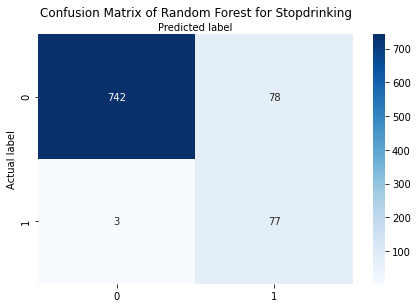

In [ ]:

confusion(confusion_matrix(testy,prd),'Confusion Matrix of Random Forest for Stopdrinking')

Text(0.5, 1.0, 'Feature Importance for Stopdrinking')

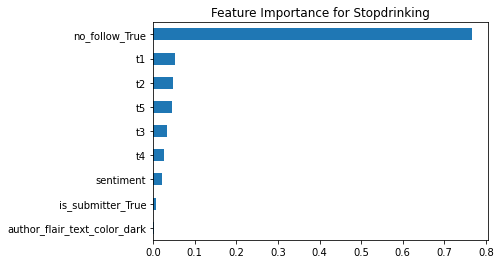

In [ ]:

feat_importances = pd.Series(model_rf.feature_importances_, trainx1.columns)
feat_importances = feat_importances.sort_values()
feat_importances.plot(kind='barh')
plt.title('Feature Importance for Stopdrinking')

In [ ]:
#logistic drink

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(trainx1, trainy1)
prd=model_lr.predict(testx)
print  (accuracy_score(trainy1, model_lr.predict(trainx1)))
print  (accuracy_score(testy, prd))
c=confusion_matrix(testy,prd)
print(confusion_matrix(testy,prd))
print(classification_report(testy,prd))
print(roc_auc_score(testy,prd))

0.9281984334203656
0.91
[[742  78]
 [  3  77]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       820
           1       0.50      0.96      0.66        80

    accuracy                           0.91       900
   macro avg       0.75      0.93      0.80       900
weighted avg       0.95      0.91      0.92       900

0.9336890243902439


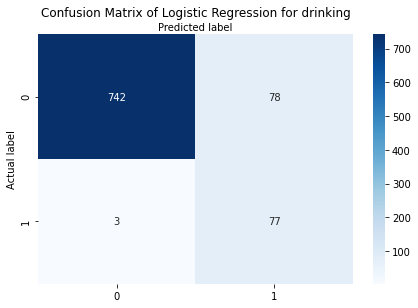

In [ ]:
confusion(c,'Confusion Matrix of Logistic Regression for drinking')

In [ ]:
#xgb drink

In [ ]:
param_test1 = {
     'learning_rate':[i/10.0 for i in range(1,4)], #0.3
     'n_estimators':range(50,500,50) #400
    }

param_test2 = {
     'max_depth':range(3,10,2), #9
     'min_child_weight':range(1,6,2) #1
    }
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)] # 0.0
    }
param_test4 = {
     'subsample':[i/10.0 for i in range(6,11)], #0.6
     'colsample_bytree':[i/10.0 for i in range(6,11)] #0.8
    }
param_test5 = {
        'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05] #0.05
    }

grid = GridSearchCV(estimator = XGBClassifier(
        objective= 'binary:logistic', 
        learning_rate=0.3,
        n_estimators=400,
        max_depth=3,
        min_child_weight=1,
        gamma=0,
        colsample_bytree=1,
        subsample=0.7,
        nthread=4, 
        scale_pos_weight=1,
        early_stopping_rounds=80,
        seed=0), 
    param_grid = param_test5, 
    scoring='accuracy',
    n_jobs=4,iid=False, cv=5)
grid.fit(trainx1,trainy1)

print("grid.best_params_", grid.best_params_)
print("grid.best_score_", grid.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


grid.best_params_ {'reg_alpha': 0.001}
grid.best_score_ 0.973107049608355


In [ ]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=80,
              gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.7, verbosity=1)

In [ ]:
clf=grid.best_estimator_

clf.fit(trainx1,trainy1)

y_train_pred = clf.predict(trainx1)
train_predictions = [round(value) for value in y_train_pred]

y_test_pred = clf.predict(testx)
test_predictions = [round(value) for value in y_test_pred]

print  (accuracy_score(trainy1, y_train_pred))
print  (accuracy_score(testy, y_test_pred))

print(confusion_matrix(testy,y_test_pred))
print(classification_report(testy,y_test_pred))
print(roc_auc_score(testy,y_test_pred))

0.9981723237597911
0.9033333333333333
[[773  47]
 [ 40  40]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       820
           1       0.46      0.50      0.48        80

    accuracy                           0.90       900
   macro avg       0.71      0.72      0.71       900
weighted avg       0.91      0.90      0.91       900

0.7213414634146341


In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='poly') 
#linear 0.934
#poly 0.935
#rbf 0.928
#sigmoid 0.822
clf.fit(trainx1, trainy1)

#Predict the response for test dataset
y_test_pred = clf.predict(testx)
y_train_prd=clf.predict(trainx1)
print  (accuracy_score(trainy1, y_train_prd))
print  (accuracy_score(testy, y_test_pred))

print(confusion_matrix(testy,y_test_pred))
print(classification_report(testy,y_test_pred))
print(roc_auc_score(testy,y_test_pred))

0.9342036553524804
0.9122222222222223
[[744  76]
 [  3  77]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       820
           1       0.50      0.96      0.66        80

    accuracy                           0.91       900
   macro avg       0.75      0.93      0.81       900
weighted avg       0.95      0.91      0.92       900

0.9349085365853658


In [ ]:
clf.coef_

AttributeError: ignored

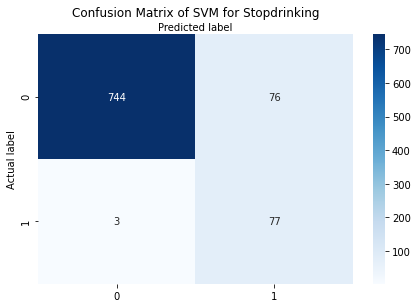

In [ ]:
c = confusion_matrix(testy,y_test_pred)
confusion(c,'Confusion Matrix of SVM for Stopdrinking')